## Visión por Computadora - Trabajo Práctico 3

Encontrar el logotipo de la gaseosa dentro de las imágenes provistas en Material_TPs/TP3/images a partir del template Material_TPs/TP3/template.

1. Obtener una detección del logo en cada imagen sin falsos positivos
2. Plantear y validar un algoritmo para múltiples detecciones en la imagen
coca_multi.png con el mismo témplate del ítem 1
3. Generalizar el algoritmo del item 2 para todas las imágenes.
Visualizar los resultados con bounding boxes en cada imagen mostrando el nivel de confianza
de la detección.

### 1. Obtener una detección del logo en cada imagen sin falsos positivos

In [2]:
%matplotlib inline

import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import glob

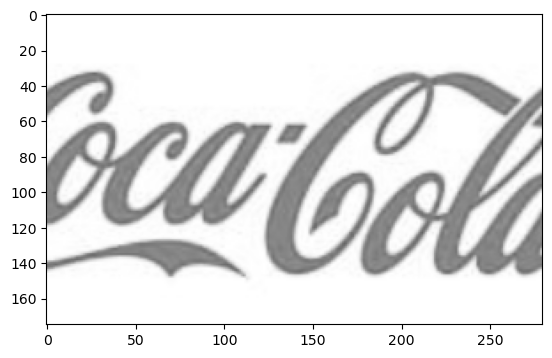

In [3]:
# Ruta a las imágenes y al template
image_paths = glob.glob('./images/*.*')
template_path = './template/pattern.png'

# Se carga el template
template = cv.imread(template_path, 0)

# Se obtienen las dimensiones del template, ancho (w) y alto (h)
template_w, template_h = template.shape[::-1]

aspect_ratio = template_w / template_h

# Se recorta el template para matchear mejor en imágenes curvas.
# Se toma 70% central del mismo
new_width = int(template_w * 0.70)
start_x = (template_w - new_width) // 2
template = template[:, start_x:start_x + new_width]

# Se muestra el template recortado
plt.figure()
plt.imshow(cv.cvtColor(template, cv.COLOR_BGR2RGB))
plt.show()

In [4]:
def match_logo(img, template, min_scale=0.25, max_scale=3, threshold=0.01):

    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    img_h, img_w = img_gray.shape
    best_match = None
    best_val = -1
    best_loc = None

    scales = np.linspace(max_scale, min_scale, 100)

    for scale in scales:
        scaled_template = cv.resize(template, None, fx=scale, fy=scale)
        scaled_template_h, scaled_template_w = scaled_template.shape
        
        if scaled_template_h <= img_h and scaled_template_w <= img_w:

            scaled_template_inverted = cv.bitwise_not(scaled_template)
            res_original = cv.matchTemplate(img_gray, scaled_template, cv.TM_CCOEFF_NORMED)
            res_inv = cv.matchTemplate(img_gray, scaled_template_inverted, cv.TM_CCOEFF_NORMED)            
            
            min_val_original, max_val_original, min_loc_original, max_loc_original = cv.minMaxLoc(res_original)
            min_val_inv, max_val_inv, min_loc_inv, max_loc_inv = cv.minMaxLoc(res_inv)

            if max_val_original > max_val_inv:
                max_val = max_val_original
                max_loc = max_loc_original
            else:
                max_val = max_val_inv
                max_loc = max_loc_inv

            if max_val > best_val:
                best_val = max_val
                best_loc = max_loc
                best_match = scaled_template

                #print(f'{max_val} scaled_template.shape: {scaled_template.shape}, max_loc: {max_loc}')

    if best_val >= threshold:
        best_w, best_h = best_match.shape[::-1]
        best_w_full = int(best_h * aspect_ratio)
        w_padding = int((best_w_full - best_w) / 2)
        
        top_left = best_loc
        top_left = (top_left[0] - w_padding, top_left[1])
        bottom_right = (min(top_left[0] + best_w_full, img.shape[1]), top_left[1] + best_h)
        top_left = (max(0, top_left[0]), top_left[1])

        cv.rectangle(img, top_left, bottom_right, (0, 255, 0), 3)
        metric = best_val
        return img, metric
    else:
        return img, None

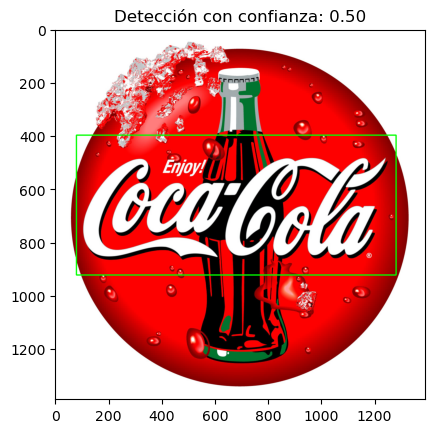

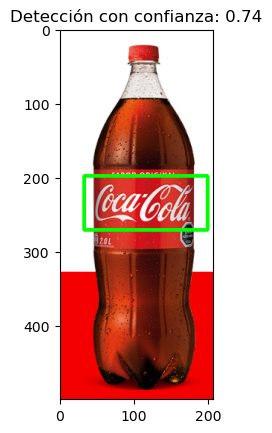

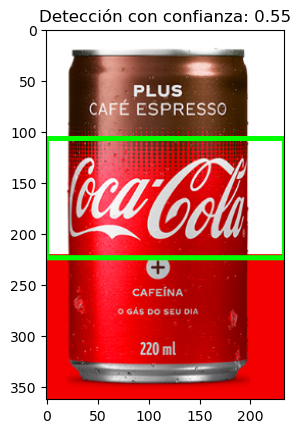

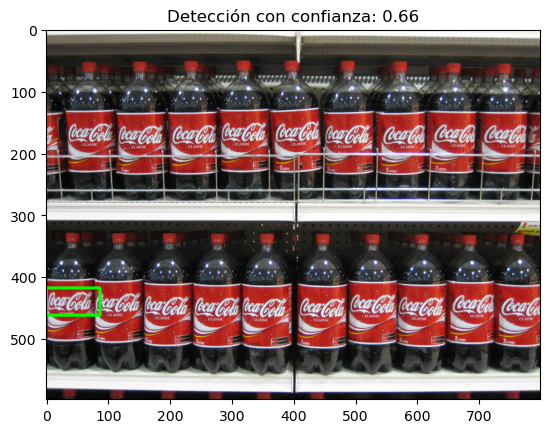

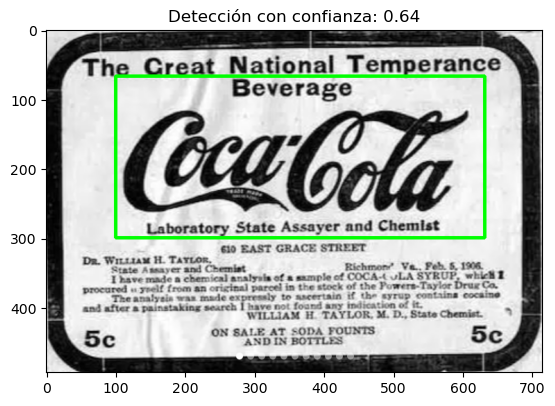

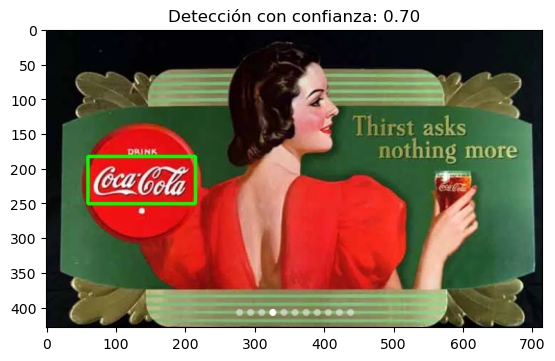

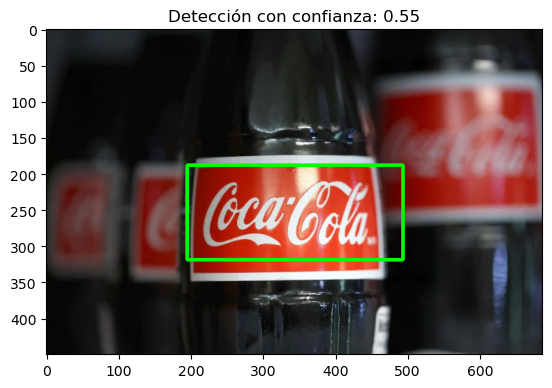

In [5]:
# Mostrar resultados
for image_path in image_paths:
    img = cv.imread(image_path)

    detected_img, metric = match_logo(img, template)

    plt.figure()
    plt.imshow(cv.cvtColor(detected_img, cv.COLOR_BGR2RGB))
    if metric:
        plt.title(f'Detección con confianza: {metric:.2f}')
    else:
        plt.title('No se detectó el logotipo')
    plt.show()

### 2. Plantear y validar un algoritmo para múltiples detecciones en la imagen coca_multi.png con el mismo témplate del ítem 1

### 3. Generalizar el algoritmo del item 2 para todas las imágenes.